In [ ]:
import pandas as pd

df = pd.read_csv('data_preprocessed.csv')
df.head(5)

,category,article
0,COMEDY,of the funniest tweets about cats and dogs thi...
1,PARENTING,the funniest tweets from parents this week sep...
2,SPORTS,maury wills basestealing shortstop for dodgers...
3,ENTERTAINMENT,golden globes returning to nbc in january afte...
4,POLITICS,biden says us forces would defend taiwan if ch...


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = df.dropna()
df = df.astype(str)

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Function to convert NLTK tag to WordNet tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    word_pos_tags = nltk.pos_tag(nltk.word_tokenize(text)) # Tokenize text and get word parts of speech
    lemmatized_words = []

    for word, tag in word_pos_tags:
        wntag = get_wordnet_pos(tag)
        if wntag is None:  # if no tag, consider it a noun
            lemmatized_words.append(lemmatizer.lemmatize(word))
        else:
            lemmatized_words.append(lemmatizer.lemmatize(word, pos=wntag))

    return ' '.join(lemmatized_words)

# Apply lemmatization to each article
df['article'] = df['article'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def prepare_tokenizer(texts, unknown_token="<UNK>", max_length=200):
    tokenizer = Tokenizer(oov_token=unknown_token)
    tokenizer.fit_on_texts(texts)
    return tokenizer, max_length

In [ ]:
def encode_sequences(tokenizer, texts, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='pre')
    return padded_sequences

In [ ]:
def encode_labels(labels):
    label_indices = labels.astype('category').cat.codes
    return to_categorical(label_indices)

In [ ]:
def split_dataset(X, Y, test_size=0.2, random_state=50):
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)


In [ ]:
# Load GloVe model
def load_glove_embeddings(glove_file_path, embedding_dim, word_index):
    embeddings_index = {}

    with open(glove_file_path, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [ ]:
def build_lstm_model(embed_matrix, input_length, num_classes, lstm_units=128, dense_units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(len(embed_matrix), embed_matrix.shape[1], weights=[embed_matrix], input_length=input_length, trainable=False))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [ ]:
tokenizer, max_length = prepare_tokenizer(df['article'])
X = encode_sequences(tokenizer, df['article'], max_length)
Y = encode_labels(df['category'])

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, Y)


In [ ]:
embedding_matrix = load_glove_embeddings('glove.6B.200d.txt', 200, tokenizer.word_index)

In [ ]:
batch_size = 32
epoch_num = 10
model = build_lstm_model(embedding_matrix, max_length, y_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_num, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
2780/2780 [==============================] - 67s 23ms/step - loss: 0.9169 - accuracy: 0.7198 - val_loss: 0.6963 - val_accuracy: 0.7804
Epoch 2/10
2780/2780 [==============================] - 58s 21ms/step - loss: 0.7018 - accuracy: 0.7902 - val_loss: 0.6385 - val_accuracy: 0.8010
Epoch 3/10
2780/2780 [==============================] - 58s 21ms/step - loss: 0.6488 - accuracy: 0.8048 - val_loss: 0.6668 - val_accuracy: 0.7948
Epoch 4/10
2780/2780 [==============================] - 59s 21ms/step - loss: 0.6328 - accuracy: 0.8106 - val_loss: 0.6366 - val_accuracy: 0.8123
Epoch 5/10
2780/2780 [==============================] - 58s 21ms/step - loss: 0.5992 - accuracy: 0.8213 - val_loss: 0.6764 - val_accuracy: 0.8111
Epoch 6/10
2780/2780 [==============================] - 58s 21ms/step - loss: 0.5759 - accuracy: 0.8283 - val_loss: 0.7060 - val_accuracy: 0.8109
Epoch 7/10
2780/2780 [==============================] - 58s 21ms/step - loss: 0.6073 - accuracy: 0.8221 - val_loss: 0.7738 -

869/869 [==============================] - 10s 11ms/step


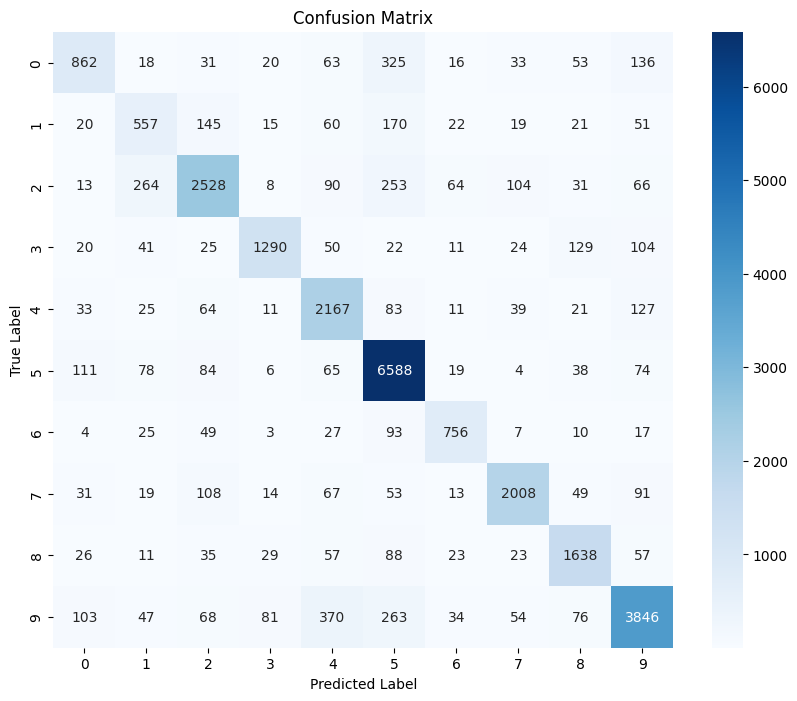

In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Accuracy Score
accuracy_score = sklearn.metrics.accuracy_score(y_true, y_pred_classes)
print("accuracy_score of test set:", accuracy_score)

accuracy_score of test set: 0.8001439107753193


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.55      0.62      1557
           1       0.51      0.52      0.51      1080
           2       0.81      0.74      0.77      3421
           3       0.87      0.75      0.81      1716
           4       0.72      0.84      0.77      2581
           5       0.83      0.93      0.88      7067
           6       0.78      0.76      0.77       991
           7       0.87      0.82      0.84      2453
           8       0.79      0.82      0.81      1987
           9       0.84      0.78      0.81      4942

    accuracy                           0.80     27795
   macro avg       0.77      0.75      0.76     27795
weighted avg       0.80      0.80      0.80     27795

